In [781]:
%load_ext autoreload
%autoreload 2
import numpy as np
import enum
import copy
import connect4.connect4 as game
from pympler import asizeof
import deeplearning.buffer as buf
import torch 
import torch.nn as nn
import torch.optim as optim
import deeplearning.mlp as mlp
import torch.nn.functional as F
import picture_maker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [782]:
env = game.Connect4()
randomPlayer1 = game.RandomPlayer()
greedyPlayer2 = game.GreedyRandomPlayer()
detPlayer3 = game.DetPlayer()
smartPlayer4 = game.SmartPlayer()
buffer = buf.ReplayBuffer(20000)

In [783]:
gm = game.GameManager([detPlayer3, smartPlayer4])
gm.play(10000, game.Connect4, buffer)
gm.info()

gm = game.GameManager([detPlayer3, greedyPlayer2])
gm.play(5000, game.Connect4, buffer)
gm.info()

gm = game.GameManager([detPlayer3, randomPlayer1])
gm.play(5000, game.Connect4, buffer)
gm.info()

p1:  0.2263 p2:  0.7719 draw:  0.0018
p1:  0.3232 p2:  0.6746 draw:  0.0022
p1:  0.172 p2:  0.8276 draw:  0.0004


In [911]:
randomPlayer1.elo, smartPlayer4.elo, greedyPlayer2.elo, detPlayer3.elo

(762.0, 1071.0, 921.0, 1163.0)

In [916]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

bf = mlp.BF(42, 7, 5000, 1, device).to(device)
optimizer = optim.Adam(params=bf.parameters(), lr=1e-3)

In [917]:
def train_behavior_function(batch_size, model, optimizer):
    """
    Trains the BF with on a cross entropy loss were the inputs are the action probabilities based on the state and command.
    The targets are the actions appropriate to the states from the replay buffer.
    """
    X, y = buffer.create_training_examples(batch_size)


    X = torch.stack(X)


    state = X[:,0:42]
    d = X[:,42:42+1]
    e = X[:,43:43+1]
    command = torch.cat([d, e], dim=-1)
    y = torch.FloatTensor((y)).to(device).long()
    y_ = model(state.to(device), command.to(device)).float()
    optimizer.zero_grad()
    pred_loss = F.cross_entropy(y_, y)   
    pred_loss.backward()
    optimizer.step()
    return pred_loss.detach().cpu().numpy()

def run_loop():
    i = 0
    cum_loss = 0
    best_loss = 100
    best_loss_i = 0
    while True:
        i += 1
        loss = train_behavior_function(1000, bf, optimizer)
        if loss < best_loss - 0.01:
            best_loss = loss
            best_loss_i = i
        if i - best_loss_i > 200:
            print("early stopping")
            return
        cum_loss += loss
        if i % 100 == 0:
            print(i, cum_loss, best_loss_i, best_loss)
            cum_loss = 0
run_loop()

100 182.13413274288177 97 1.650954
200 155.7022407054901 200 1.3987792
300 142.27056169509888 300 1.342599
400 135.52174949645996 361 1.2866718
500 130.44649481773376 457 1.2331758
600 127.74500179290771 562 1.1843228
700 125.4245582818985 693 1.1647626
800 122.76085102558136 693 1.1647626
900 121.50166964530945 881 1.1506974
1000 120.83043277263641 906 1.1387709
1100 119.90136468410492 1068 1.1164771
1200 118.64005315303802 1068 1.1164771
early stopping


In [918]:
with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, greedyPlayer2])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, detPlayer3])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, randomPlayer1])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, smartPlayer4])
    gm.play(1000, game.Connect4, buf2, 1060.0)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

#p1:  0.708 p2:  0.291 draw:  0.001
# p1:  0.262 p2:  0.737 draw:  0.001
# p1:  0.761 p2:  0.239 draw:  0.0
# p1:  0.484 p2:  0.516 draw:  0.0

p1:  0.707 p2:  0.291 draw:  0.002
p1:  0.388 p2:  0.609 draw:  0.003
p1:  0.806 p2:  0.194 draw:  0.0
p1:  0.608 p2:  0.391 draw:  0.001


In [790]:
with torch.no_grad():
    buf2 = buf.ReplayBuffer(1)
    gm = game.GameManager([bf, detPlayer3])
    gm.play(1000, game.Connect4, buf2, 1060)
    gm.info() # p1:  0.6 p2:  0.4 draw:  0.0

p1:  0.5 p2:  0.5 draw:  0.0


In [791]:
def viewer(a):
    print("https://connect4.gamesolver.org/en/?pos=" + "".join([str(x+1) for x in a]))

In [794]:
[viewer(buf2.buffer[1000-1-i]['actions']) for i in range(5)]
[buf2.buffer[1000-1-i]['elo'] for i in range(5)]

https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343
https://connect4.gamesolver.org/en/?pos=3434343


[[1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0],
 [1052.0, 1055.0]]

In [56]:
bf = mlp.BF.load("7")

In [576]:
env = game.Connect4_pre()

In [887]:
a = bf.steps([s.flatten()], 1, 1187/1000)[0]
b = bf.steps([s.flatten()], -1, 1187/1000)[0]
a, b

(array([0.21295665, 0.15185957, 0.11858324, 0.1764231 , 0.13977778,
        0.12648764, 0.07391201], dtype=float32),
 array([0.0870048 , 0.12200911, 0.1562468 , 0.10502168, 0.13255504,
        0.14648269, 0.25067985], dtype=float32))

In [892]:
s = env.reset()

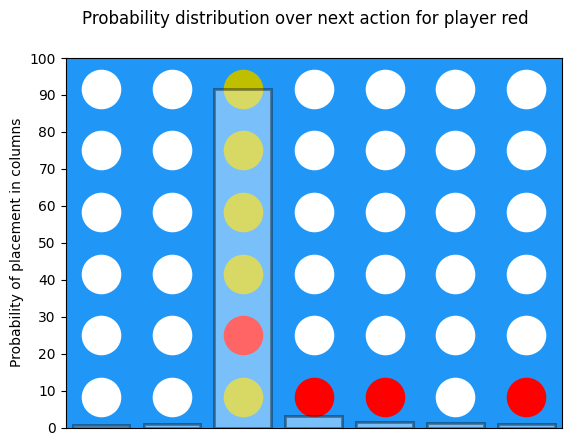

[[0.00718128 0.00910731 0.91469145 0.03057095 0.01515569 0.01347593
  0.00981727]]
[[0.2652873  0.20918378 0.00208278 0.06231737 0.12570204 0.14137065
  0.1940561 ]]
[[-0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0.]
 [-0. -0.  1. -0. -0. -0. -0.]
 [-0. -0. -1.  1.  1. -0.  1.]]


In [901]:
x = bf.steps([s.flatten()], 1, 1021/1000)
z = bf.steps([s.flatten()], -1, 1021/1000)
s, a, d, i = env.step(x[0])
picture_maker.make_prob_overlay(s.astype(int), x[0]) # 0.11676659 0.10735492 0.22579594 0.22034153 0.11116898 0.10928161 0.10929052
print(x)
print(z)
print(s)

In [227]:
print(bf.commands.weight)

Parameter containing:
tensor([[ 0.0157,  0.4921],
        [ 0.4833,  0.3826],
        [ 0.0950,  0.2892],
        ...,
        [ 0.5773, -0.4340],
        [ 0.3175,  0.4930],
        [-0.3016, -0.0639]], device='cuda:0', requires_grad=True)


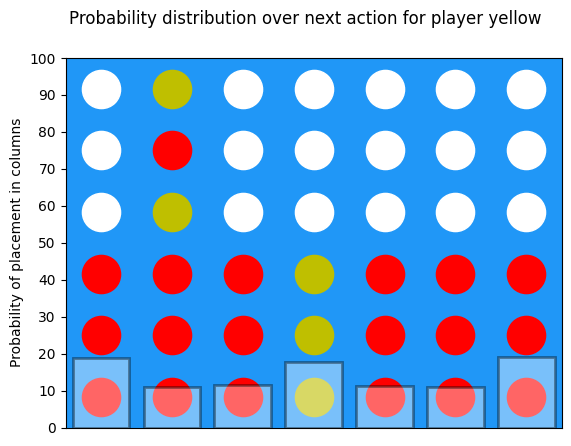

[[-0. -1. -0. -0. -0. -0. -0.]
 [-0.  1. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0.]
 [ 1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1.  1.  1.  1.]]


In [539]:
s, a, d, i = env.step([0, 1, 0, 0, 0, 0, 0])
picture_maker.make_prob_overlay(s.astype(int), x[0])
print(s)

In [744]:
s

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1.,  0., -1.,  0.,  1.,  0.],
       [ 1.,  1.,  1., -1.,  1., -1.,  0.]])

In [780]:
# some fun visualizers
# elo
a = env.reset()
for x in range(0, 2000, 100):
    print(x, bf.steps([a], 1, x/1000)[0][3])


0 0.2852396
100 0.29896984
200 0.31292817
300 0.32814944
400 0.34263092
500 0.35605574
600 0.36897996
700 0.38082322
800 0.39279935
900 0.40406778
1000 0.41483378
1100 0.42620927
1200 0.4369834
1300 0.44679278
1400 0.4557999
1500 0.46470174
1600 0.4738076
1700 0.48318848
1800 0.49230918
1900 0.50117314
